# Predicting bike rentals in a day

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb
from sklearn import preprocessing

## Import data and inspect

In [2]:
bikes=pd.read_csv('day.csv') #see readme file for info about the dataset

In [38]:
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


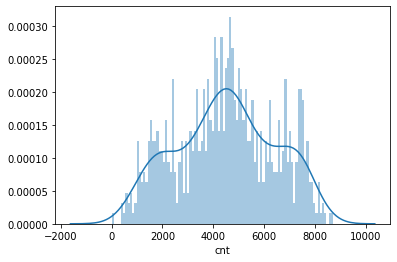

In [39]:
sns.distplot(bikes['cnt'],bins=100)

In [10]:
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [4]:
bikes.corr()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.412224,0.866025,0.496702,0.016145,-0.000016,-0.004337,-0.021477,0.150580,0.152638,0.016375,-0.112620,0.275255,0.659623,0.628830
season,0.412224,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.210399,0.411623,0.406100
yr,0.866025,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.248546,0.594248,0.566710
mnth,0.496702,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.123006,0.293488,0.279977
holiday,0.016145,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.054274,-0.108745,-0.068348
weekday,-0.000016,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.059923,0.057367,0.067443
workingday,-0.004337,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.518044,0.303907,0.061156
weathersit,-0.021477,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.247353,-0.260388,-0.297391
temp,0.150580,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.543285,0.540012,0.627494
atemp,0.152638,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.543864,0.544192,0.631066


The features temp is highly correlated with atemp so atemp will be dropped \
Season is highly correlated with month, since month provides us with more information, season will be dropped

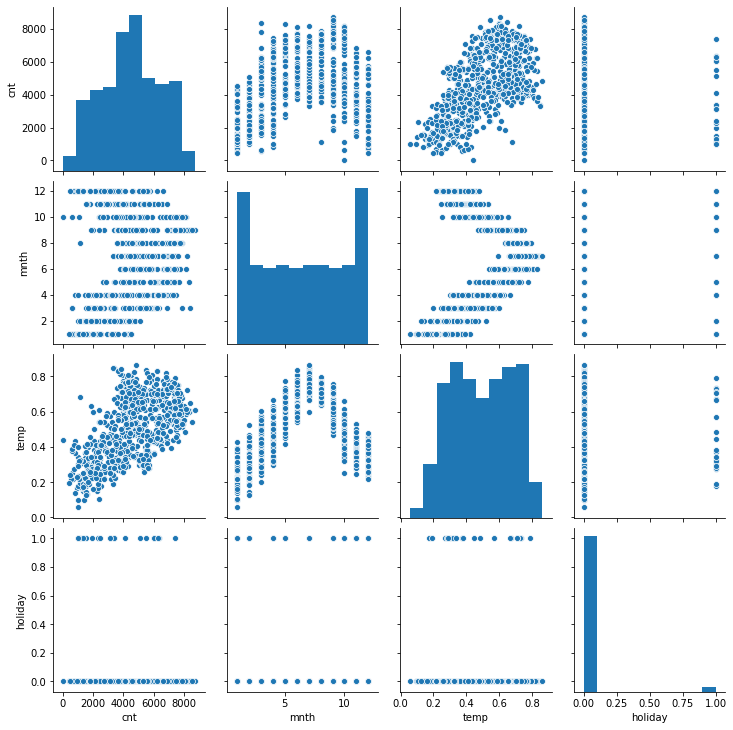

In [5]:
# Find outliers
features=bikes[['cnt','mnth','temp','holiday']]
sns.pairplot(features,height=2.5)

There are 4 outliers in the months of August and October where the number of bike rentals was below 2000

In [6]:
bikes.skew()

instant       0.000000
season       -0.000384
yr           -0.002742
mnth         -0.008149
holiday       5.654224
weekday       0.002742
workingday   -0.793147
weathersit    0.957385
temp         -0.054521
atemp        -0.131088
hum          -0.069783
windspeed     0.677345
casual        1.266454
registered    0.043659
cnt          -0.047353
dtype: float64

Holiday and weathersit are highly skewed

In [3]:
drop_list=['atemp','workingday','instant','casual','registered'] 

for col in drop_list:
    bikes=bikes.drop([col], axis=1)
bikes

,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,6,2,0.344167,0.805833,0.160446,985
1,2011-01-02,1,0,1,0,0,2,0.363478,0.696087,0.248539,801
2,2011-01-03,1,0,1,0,1,1,0.196364,0.437273,0.248309,1349
3,2011-01-04,1,0,1,0,2,1,0.200000,0.590435,0.160296,1562
4,2011-01-05,1,0,1,0,3,1,0.226957,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,1,1,12,0,4,2,0.254167,0.652917,0.350133,2114
727,2012-12-28,1,1,12,0,5,2,0.253333,0.590000,0.155471,3095
728,2012-12-29,1,1,12,0,6,2,0.253333,0.752917,0.124383,1341
729,2012-12-30,1,1,12,0,0,1,0.255833,0.483333,0.350754,1796


In [41]:
#investigate the anomalies
bikes[(bikes['mnth']==10) & (bikes['cnt'] < 2000)]

,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,hum,windspeed,cnt
301,2011-10-29,4,0,10,0,6,3,0.254167,0.882500,0.351371,627
667,2012-10-29,4,1,10,0,1,3,0.440000,0.880000,0.358200,22
668,2012-10-30,4,1,10,0,2,2,0.318182,0.825455,0.213009,1096


In [4]:
#investigate the anomalies
bikes[(bikes['mnth']==8) & (bikes['cnt'] < 2000)]

,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,hum,windspeed,cnt
238,2011-08-27,3,0,8,0,6,2,0.68,0.85,0.375617,1115


The anomalies in October 2010 and 2011 and August 2011 can be explained by searching for extreme weather conditions on these days in the area. The extreme weather in all the outliers were hurricanes, so these can be removed from the data

In [5]:
#delete the anomalies
oct_anom=bikes[(bikes['mnth']==10) & (bikes['cnt'] < 2000)].index
bikes=bikes.drop(oct_anom)

In [6]:
aug_anom=bikes[(bikes['mnth']==8) & (bikes['cnt'] < 2000)].index
bikes=bikes.drop(aug_anom)

In [7]:
drop_list=['dteday','season','yr']

for col in drop_list:
    bikes=bikes.drop([col], axis=1)

In [30]:
bikes

,mnth,holiday,weekday,weathersit,temp,hum,windspeed,cnt
46,2,0,3,1,0.318261,0.423478,0.251791,2115
47,2,0,4,1,0.435833,0.505000,0.230104,2475
48,2,0,5,1,0.521667,0.516667,0.264925,2927
57,2,0,0,1,0.343478,0.680000,0.125248,2402
60,3,0,3,1,0.335000,0.449583,0.307833,2134
...,...,...,...,...,...,...,...,...
719,12,0,4,2,0.330000,0.667917,0.132463,4128
720,12,0,5,2,0.326667,0.556667,0.374383,3623
726,12,0,4,2,0.254167,0.652917,0.350133,2114
727,12,0,5,2,0.253333,0.590000,0.155471,3095


In [37]:
bikes['holiday'].value_counts()

0    706
1     21
Name: holiday, dtype: int64

In [8]:
X=bikes.iloc[:,0:-1]
y=bikes.iloc[:,-1].values

## Dummy variables

In [9]:
X_dummies = pd.get_dummies(X, columns=['mnth','weekday','weathersit'],prefix=['m','d','w'],drop_first=True)

In [10]:
X_dummies

,holiday,temp,hum,windspeed,m_2,m_3,m_4,m_5,m_6,m_7,...,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,w_2,w_3
0,0,0.344167,0.805833,0.160446,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0.363478,0.696087,0.248539,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.196364,0.437273,0.248309,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0.200000,0.590435,0.160296,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0.226957,0.436957,0.186900,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,0.254167,0.652917,0.350133,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
727,0,0.253333,0.590000,0.155471,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
728,0,0.253333,0.752917,0.124383,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
729,0,0.255833,0.483333,0.350754,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [11]:
X=X_dummies.values

## Building models

## Random forest

In [17]:
forest_regressor = RandomForestRegressor(max_depth=7,random_state=1)
cv = KFold(n_splits=5, shuffle=True,random_state=1)
cv_scores = cross_val_score(forest_regressor, X, y, cv=cv,scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv_scores)))
print(np.sqrt(np.abs(cv_scores)).mean())

[1113.26215961 1312.63979903 1194.21484685 1252.66760135 1265.85989203]
1227.7288597732027


## XGBoost

In [51]:
xg_reg = xgb.XGBRegressor(booster='gbtree', learning_rate = 0.3,max_depth = 7, n_estimators = 10)
cv = KFold(n_splits=5, shuffle=True,random_state=1)
cv_scores = cross_val_score(xg_reg, X, y, cv=cv,scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv_scores)))
print(np.sqrt(np.abs(cv_scores)).mean())

[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[1117.05914021 1350.28889704 1204.16497305 1265.8608035  1284.50927406]
1244.3766175720284


## Neural network

In [67]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [73]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [74]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
cv = KFold(n_splits=5, shuffle=True,random_state=1)
cv_scores = cross_val_score(estimator, X, y, cv=cv,scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv_scores)))
print(np.sqrt(np.abs(cv_scores)).mean())

[1280.03860831 1311.35556061 1411.91450701 1339.65941097 1364.52540469]
1341.498698320107


Random forest performs the best in this case. A **RMSE of 1200** is relatively high, however, given that the mean is around 4500 it means that the predictive model is more likely only useful when higher bike rental numbers are expected, i.e. above 2000. It is evident that several more years of data are needed to create a more reliable model